In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fire = pd.read_csv("./ca_daily_fire_2000_2021-v2.csv")
fire_filt = fire[(fire["year"] >= 2011) & (fire["year"] <= 2014) ]
fire_filt.head()

,latitude,longitude,acq_date,satellite,instrument,frp,type,bright_t31,confidence,year,month
0,32.4646,-114.6906,2011-06-29,Terra,MODIS,91.1,0,315.7,84,2011,6
1,32.4768,-114.6785,2011-10-11,Terra,MODIS,96.2,0,313.7,100,2011,10
2,32.4937,-114.7856,2013-02-06,Terra,MODIS,26.9,0,296.1,65,2013,2
5,32.5006,-114.7917,2013-02-06,Terra,MODIS,45.0,0,296.4,74,2013,2
13,32.5167,-114.7978,2011-11-05,Terra,MODIS,8.2,0,295.7,65,2011,11


In [14]:
pm = pd.read_csv("./Daily_Census_Tract-Level_PM2.5_Concentrations__2011-2014_20240413.csv")


In [5]:
fire.columns

Index(['latitude', 'longitude', 'acq_date', 'satellite', 'instrument', 'frp',
       'type', 'bright_t31', 'confidence', 'year', 'month'],
      dtype='object')

In [12]:
pm["date"][2]


'30DEC2011'

In [6]:
pm.columns

Index(['year', 'date', 'statefips', 'countyfips', 'ctfips', 'latitude',
       'longitude', 'ds_pm_pred', 'ds_pm_stdd'],
      dtype='object')

fire['StartedMonth'] = [x.month for x in wf['Started']]
monthly_count = wf.groupby(["ArchiveYear","StartedMonth"])['AcresBurned'].count().reset_index()
monthly_count.rename(columns={"AcresBurned": "WildfireCount"}, inplace=True)
monthly_count

In [25]:
precision = 3  
fire['rounded_latitude'] = fire['latitude'].round(precision)
fire['rounded_longitude'] = fire['longitude'].round(precision)
pm['rounded_latitude'] = pm['latitude'].round(precision)
pm['rounded_longitude'] = pm['longitude'].round(precision)

In [9]:
monthly_count = fire_filt.groupby(["year","month"])['frp'].count().reset_index()
monthly_count.rename(columns={"frp": "frpcount"}, inplace=True)
monthly_count.head()

,year,month,frpcount
0,2011,1,95
1,2011,2,220
2,2011,3,111
3,2011,4,243
4,2011,5,137


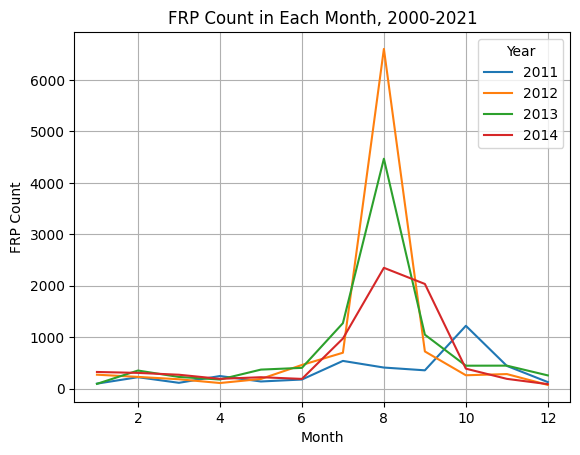

In [10]:
monthly_count['month'] = pd.Categorical(monthly_count['month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                                        ordered=True)
                                        
for year in monthly_count['year'].unique():
    subset = monthly_count[monthly_count['year'] == year]
    plt.plot(subset['month'], subset['frpcount'], label=str(year))

plt.title('FRP Count in Each Month, 2011-2014')  # Title
plt.xlabel('Month')  # X-axis label
plt.ylabel('FRP Count')  # Y-axis label
plt.legend(title='Year', loc='upper right')  # Legend with title
plt.grid(True)  # Optional: add grid for better readability

In [ ]:
monthly_count = pm.groupby(["year","month"])['frp'].count().reset_index()
monthly_count.rename(columns={"frp": "frpcount"}, inplace=True)
monthly_count.head()

In [16]:
pm['date_parsed'] = pd.to_datetime(pm['date'], format='%d%b%Y')
pm['month'] = pm['date_parsed'].dt.month
pm.head()

,year,date,statefips,countyfips,ctfips,latitude,longitude,ds_pm_pred,ds_pm_stdd,date_parsed,month
0,2011,30DEC2011,48,48399,48399950100,31.96861,-99.99100,7.590561,5.439812,2011-12-30,12
1,2011,30DEC2011,48,48399,48399950200,31.95574,-99.96764,7.660033,5.666294,2011-12-30,12
2,2011,30DEC2011,48,48399,48399950500,31.65529,-100.05925,7.355021,5.490203,2011-12-30,12
3,2011,30DEC2011,48,48399,48399950600,31.76387,-99.89893,7.436393,5.247210,2011-12-30,12
4,2011,30DEC2011,48,48401,48401950100,32.31673,-94.60574,11.107991,6.297006,2011-12-30,12


In [23]:
pm_cali = pm[pm["statefips"]== 6]
pm_cali.head()

,year,date,statefips,countyfips,ctfips,latitude,longitude,ds_pm_pred,ds_pm_stdd,date_parsed,month
10645,2011,31DEC2011,6,6001,6001400100,37.86754,-122.23181,8.143539,4.009139,2011-12-31,12
10646,2011,31DEC2011,6,6001,6001400200,37.84817,-122.24948,8.116514,3.971881,2011-12-31,12
10647,2011,31DEC2011,6,6001,6001400300,37.84056,-122.25442,8.083649,3.933703,2011-12-31,12
10648,2011,31DEC2011,6,6001,6001400400,37.84801,-122.25752,8.180107,4.215300,2011-12-31,12
10649,2011,31DEC2011,6,6001,6001400500,37.84853,-122.26480,8.125882,4.103174,2011-12-31,12


In [27]:
monthly_pm_cali = pm_cali.groupby(["year","month"])['ds_pm_pred'].mean().reset_index()
monthly_pm_cali.rename(columns={"ds_pm_pred": "pm_level"}, inplace=True)
monthly_pm_cali["year"].unique()

array([2011, 2012, 2013, 2014])

In [28]:
monthly_pm_cali.head()

,year,month,pm_level
0,2011,1,13.283995
1,2011,2,8.666981
2,2011,3,7.220850
3,2011,4,7.737372
4,2011,5,7.729165


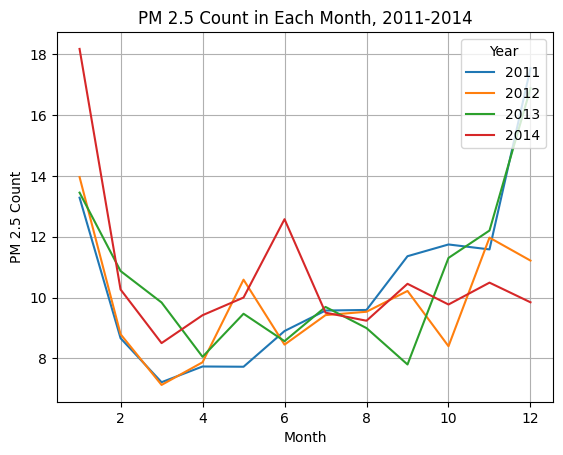

In [29]:
monthly_pm_cali['month'] = pd.Categorical(monthly_pm_cali['month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ordered=True)
                                        
for year in monthly_pm_cali['year'].unique():
    subset = monthly_pm_cali[monthly_pm_cali['year'] == year]
    plt.plot(subset['month'], subset['pm_level'], label=str(year))

plt.title('PM 2.5 Count in Each Month, 2011-2014')  # Title
plt.xlabel('Month')  # X-axis label
plt.ylabel('PM 2.5 Count')  # Y-axis label
plt.legend(title='Year', loc='upper right')  # Legend with title
plt.grid(True)  # Optional: add grid for better readability

In [30]:
merged_df = pd.merge(monthly_pm_cali, monthly_count, how='left', left_on=['year', 'month'], right_on=['year', 'month'])
merged_df.head()

,year,month,pm_level,frpcount
0,2011,1,13.283995,95
1,2011,2,8.666981,220
2,2011,3,7.220850,111
3,2011,4,7.737372,243
4,2011,5,7.729165,137


In [ ]:
merged_df.scatter_plot()

In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return haversine((lat1, lon1), (lat2, lon2))

def categorize_distance(distance):
    if distance < 10:
        return '0-10 km'
    elif distance < 50:
        return '10-50 km'
    elif distance < 100:
        return '50-100 km'
    else:
        return '100+ km'

# Calculate distances for each row in the merged dataset
merged_df['distance'] = merged_df.apply(
    lambda row: calculate_distance(row['latitude_x'], row['longitude_x'], row['latitude_y'], row['longitude_y']),
    axis=1
)

# Categorize distances
merged_df['distance_category'] = merged_df['distance'].apply(categorize_distance)

# Remove unnecessary columns for visualization
cleaned_df = merged_df[['date', 'ds_pm_pred', 'distance_category']]

# Group by date and distance category to calculate average PM 2.5 levels
final_df = cleaned_df.groupby(['date', 'distance_category']).mean().reset_index()

# Print final prepared DataFrame
print(final_df.head())


In [ ]:
# Assuming df_fire and df_pm are your pre-loaded datasets
# You would need to preprocess these datasets as described above.

# Example of plotting
plt.figure(figsize=(10, 6))
for category in distance_categories:
    subset = df_pm[df_pm['distance_category'] == category]
    plt.plot(subset['date'], subset['ds_pm_pred'], label=f'Distance: {category} km')

plt.xlabel('Date')
plt.ylabel('PM 2.5 Levels')
plt.title('PM 2.5 Levels Over Time by Proximity to Wildfire Events')
plt.legend()
plt.show()